🎵 MUSIC RECOMMENDATION SYSTEM 

Importing Libraries

 We import libraries like pandas, numpy, seaborn, and sklearn  essential for analyzing data and training our recommendation model.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Load dataset
DATA_PATH = "music.csv"   
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (100, 16)
Columns: ['id', 'name', 'duration', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'danceability', 'repeated_plays', 'timestamp']


,id,name,duration,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability,repeated_plays,timestamp
0,4ZtFanR9U6ndgddUvNcjcG,Good 4 U Olivia Rodrigo,2.97,0.664,9,-5.044,1,0.1540,0.33500,0.000,0.0849,0.688,166.928,0.563,1,08:00:00
1,5fxyZf6m2xHeSrOzUfcJrq,Stay The Kid LAROI & Justin Bieber,2.30,0.506,8,-11.275,1,0.0589,0.37900,0.868,0.1100,0.454,170.054,0.564,0,08:00:00
2,5nujrmhLynf4yMoMtj8AQF,Levitating Dua Lipa feat. DaBaby,3.38,0.825,6,-3.787,0,0.0601,0.00883,0.000,0.0674,0.915,102.977,0.702,1,09:20:00
3,4iJyoBOLtHqaGxP12qzhQI,Peaches Justin Bieber feat. Daniel Caesar & Gi...,3.30,0.696,0,-6.181,1,0.1190,0.32100,0.000,0.4200,0.464,90.030,0.677,0,10:20:00
4,1SC5rEoYDGUK4NfG82494W,Montero (Call Me By Your Name) Lil Nas X,2.30,0.503,8,-6.725,0,0.2200,0.29300,0.000,0.4050,0.710,178.781,0.593,1,11:20:00


 Loading the Dataset
 
Quick EDA & Preprocessing

Load the dataset (music.csv) which contains user listening history.
Each entry may represent a song play with a target column (1 = replayed within a month).
data = pd.read_csv("music.csv")

In [12]:
df = pd.read_csv("music.csv", on_bad_lines='skip')  # or "music.tsv" with sep='\t' if it's a TSV file

print("Initial data loaded successfully!")
print(f"Initial shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Process timestamp column
if 'timestamp' in df.columns:
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        print("✓ Timestamp column processed successfully")
        
        # Optional: Check if any timestamps failed to parse
        failed_parses = df['timestamp'].isna().sum()
        if failed_parses > 0:
            print(f"Warning: {failed_parses} timestamp values could not be parsed and were set to NaT")
            
    except Exception as e:
        print("Warning: timestamp parse error:", e)
else:
    print("No 'timestamp' column found in the dataset")

print("\nDtype summary:")
print(df.dtypes)

print("\nValue counts for target 'repeated_plays':")
if 'repeated_plays' in df.columns:
    print(df['repeated_plays'].value_counts())
else:
    print("'repeated_plays' column not found!")

# Check essential columns
essential_cols = ['duration','energy','loudness','speechiness','acousticness',
                  'instrumentalness','liveness','valence','tempo','danceability','repeated_plays']

# Check for missing columns
missing_cols = [c for c in essential_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Required columns missing: {missing_cols}")
else:
    print("✓ All essential columns are present")

# Drop rows with missing values in essential columns
initial_rows = len(df)
df = df.dropna(subset=essential_cols).reset_index(drop=True)
final_rows = len(df)
rows_removed = initial_rows - final_rows

print(f"After dropping NAs, shape: {df.shape}")
print(f"Rows removed due to missing values: {rows_removed}")

print("\n✓ Data preprocessing completed successfully!")

Initial data loaded successfully!
Initial shape: (100, 16)
Columns: ['id', 'name', 'duration', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'danceability', 'repeated_plays', 'timestamp']
✓ Timestamp column processed successfully

Dtype summary:
id                          object
name                        object
duration                   float64
energy                     float64
key                          int64
loudness                   float64
mode                         int64
speechiness                float64
acousticness               float64
instrumentalness           float64
liveness                   float64
valence                    float64
tempo                      float64
danceability               float64
repeated_plays               int64
timestamp           datetime64[ns]
dtype: object

Value counts for target 'repeated_plays':
repeated_plays
0    52
1    47
2     1
Name: count, dtype: int6

C:\Users\ACG\AppData\Local\Temp\ipykernel_20720\3560409023.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


 Data Preprocessing
 
Feature selection & label

Clean missing values, encode categorical data, and prepare for model training.

In [13]:
feature_cols = ['duration','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','danceability']

X = df[feature_cols].copy()
y = df['repeated_plays'].astype(int).copy()   # 1 if replayed within a month (given)

# Quick sanity: scale X for models that need it / and for nearest neighbors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler for later usage
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved to scaler.pkl")


Scaler saved to scaler.pkl


Feature Scaling & Model Training

Train/test split and train RandomForest classifier

Scale numerical features to improve model performance.

Train a RandomForest model to predict replay likelihood.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Ensure labels are clean binary integers (0/1)
if df['repeated_plays'].dtype != 'int64' and df['repeated_plays'].dtype != 'int32':
    try:
        df['repeated_plays'] = df['repeated_plays'].astype(int)
    except:
        # In case it's text like "Yes"/"No"
        df['repeated_plays'] = df['repeated_plays'].apply(lambda x: 1 if str(x).lower() in ['yes', '1', 'true'] else 0)

y = df['repeated_plays'].copy()

# Fix potential issues with stratify (it fails if one class has only 1 sample)
if y.value_counts().min() < 2:
    stratify_param = None
else:
    stratify_param = y

# Safe train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=stratify_param
)

# Initialize and train RandomForest
clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
try:
    y_proba = clf.predict_proba(X_test)[:, 1]
except Exception:
    y_proba = np.zeros_like(y_pred)  # fallback

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 4))
try:
    print(" ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
except Exception as e:
    print(" ROC AUC not computed:", e)

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Save model
joblib.dump(clf, "music_recommendation_model.pkl")
print("Model saved to music_recommendation_model.pkl")



 Accuracy: 0.55
 ROC AUC: 0.6061

Classification report:
               precision    recall  f1-score   support

           0     0.6000    0.5455    0.5714        11
           1     0.5000    0.5556    0.5263         9

    accuracy                         0.5500        20
   macro avg     0.5500    0.5505    0.5489        20
weighted avg     0.5550    0.5500    0.5511        20

Confusion matrix:
 [[6 5]
 [4 5]]
Model saved to music_recommendation_model.pkl


Model Evaluation & Personalized Recommendations
Add predicted replay probability back to dataframe
Evaluate model accuracy and create personalized recommendationsbased on predicted replay probabilities.

In [15]:
df['replay_prob'] = clf.predict_proba(X_scaled)[:,1]

# Keep human-friendly columns for display
display_cols = ['id','name','replay_prob','repeated_plays'] + feature_cols
print("Sample with predicted probabilities:")
display(df[display_cols].sort_values('replay_prob', ascending=False).head(10))


Sample with predicted probabilities:


,id,name,replay_prob,repeated_plays,duration,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability
63,4xqrdfXkTW4T0RauPLv3WA,Heather Conan Gray,0.960000,1,3.30,0.425,-7.301,0.0333,0.58400,0.000000,0.3220,0.2700,102.078,0.357
21,5rZlwNFl01HqLWBQGryKSm,Mood Swings (feat. Lil Tjay) Pop Smoke,0.940000,1,3.56,0.602,-6.335,0.3680,0.48700,0.000000,0.0848,0.2690,179.798,0.480
36,0MvxgmXHMXh70GpnR0mKkT,Tusa KAROL G & Nicki Minaj,0.918889,1,3.37,0.701,-3.275,0.2830,0.30800,0.000078,0.0516,0.6190,100.954,0.796
9,6HU7h9RYOaPRFeh0R3UeAr,Deja Vu Olivia Rodrigo,0.900000,1,3.59,0.612,-7.222,0.1120,0.58400,0.000006,0.3700,0.1780,180.917,0.442
79,3eekarcy7kvN4yt5ZFzltW,HIGHEST IN THE ROOM Travis Scott,0.895556,1,2.93,0.427,-8.764,0.0317,0.05460,0.000006,0.2100,0.0605,76.469,0.598
58,3CRDbSIZ4r5MsZ0YwxuEkn,Stressed Out twenty one pilots,0.888333,1,3.37,0.637,-5.677,0.1410,0.04620,0.000023,0.0602,0.6480,169.977,0.734
28,2P2kJEIAXutA2J7DXW1Wux,LA CANCIÓN J Balvin & Bad Bunny,0.886667,1,4.04,0.646,-5.795,0.3190,0.15200,0.000018,0.1080,0.4290,176.088,0.756
56,6rZk29Yz8ObEwtJOIaACt5,DÁKITI Bad Bunny & Jhay Cortez,0.880000,1,3.22,0.186,-6.421,0.0352,0.00462,0.403000,0.1540,0.2110,109.201,0.373
68,2VxeLyX666F8uXCJ0dZF8B,Shallow Lady Gaga & Bradley Cooper,0.870667,1,3.60,0.385,-6.362,0.0308,0.37100,0.000000,0.2310,0.3230,95.799,0.572
46,2MOoIbJWIYikwIXjBDe26i,París in the Rain Lauv,0.861667,1,3.41,0.408,-9.419,0.0530,0.77100,0.000008,0.3940,0.5250,79.705,0.406


Global Top-N recommendations (trending songs)

In [16]:

def top_n_trending(df, n=10, min_listens=None):
    """
    Returns top-n songs ranked by predicted replay probability.
    min_listens is unused here (dataset doesn't have global listen_count column),
    but kept for API completeness.
    """
    top = df.sort_values('replay_prob', ascending=False).head(n)
    return top[['id','name','replay_prob','repeated_plays']]

# Example: top 5 trending songs
print("Top 5 trending songs (predicted replay probability):")
display(top_n_trending(df, n=5))


Top 5 trending songs (predicted replay probability):


,id,name,replay_prob,repeated_plays
63,4xqrdfXkTW4T0RauPLv3WA,Heather Conan Gray,0.960000,1
21,5rZlwNFl01HqLWBQGryKSm,Mood Swings (feat. Lil Tjay) Pop Smoke,0.940000,1
36,0MvxgmXHMXh70GpnR0mKkT,Tusa KAROL G & Nicki Minaj,0.918889,1
9,6HU7h9RYOaPRFeh0R3UeAr,Deja Vu Olivia Rodrigo,0.900000,1
79,3eekarcy7kvN4yt5ZFzltW,HIGHEST IN THE ROOM Travis Scott,0.895556,1


Light personalization using Similarity and replay probability

In [17]:
nn = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute')  # 11 because first neighbor is the song itself
nn.fit(X_scaled)

def recommend_for_seed_songs(seed_song_names, df, top_k=10, weight_similarity=0.6):
    """
    seed_song_names: list of song 'name' strings that user likes (1-3 names recommended)
    Returns a list of recommended songs ranked by combined (similarity * weight + replay_prob * (1-weight)).
    """
    # Find seed indices by name (case-insensitive substring match)
    indices = []
    for s in seed_song_names:
        mask = df['name'].str.contains(s, case=False, na=False)
        if mask.any():
            # take the top match
            idx = df[mask].index[0]
            indices.append(idx)
        else:
            print(f"Warning: seed song '{s}' not found in dataset. Try different text.")
    if not indices:
        return pd.DataFrame()  # nothing to recommend

    # collect neighbors for each seed
    candidate_idxs = set()
    for idx in indices:
        dist, neigh_idx = nn.kneighbors([X_scaled[idx]], n_neighbors=11)
        # neigh_idx is an array[[...]] ; skip 0 (itself)
        for i, d in zip(neigh_idx[0][1:], dist[0][1:]):
            candidate_idxs.add(int(i))

    # Build candidate df
    cand = df.loc[list(candidate_idxs)].copy()
    # Compute similarity scores: smaller cosine distance -> higher similarity; convert distance to sim = 1 - dist
    sims = []
    for idx in cand.index:
        # compute mean similarity to all seeds
        total_sim = 0
        for seed_idx in indices:
            # compute cosine distance
            dist = np.linalg.norm(X_scaled[idx] - X_scaled[seed_idx])  # Euclidean on scaled features approx
            # convert to similarity (bounded)
            sim = 1 / (1 + dist)
            total_sim += sim
        sims.append(total_sim / len(indices))
    cand['similarity_score'] = sims

    # Combined score: weight * similarity + (1-weight) * replay_prob (normalized)
    # Normalize replay_prob to 0-1 (already 0-1), similarity roughly 0-1-ish. We'll scale similarity
    cand['combined_score'] = weight_similarity * cand['similarity_score'] + (1 - weight_similarity) * cand['replay_prob']

    # Exclude seeds themselves from recommendations
    seed_ids = df.loc[indices, 'id'].tolist()
    cand = cand[~cand['id'].isin(seed_ids)]

    # Return top K
    return cand.sort_values('combined_score', ascending=False).head(top_k)[['id','name','combined_score','replay_prob','similarity_score']]

# Example usage:
print("Personalized recommendations (example seeds: choose 1 or 2 names from your dataset):")
display(recommend_for_seed_songs(['love','track'], df, top_k=8))


Personalized recommendations (example seeds: choose 1 or 2 names from your dataset):


,id,name,combined_score,replay_prob,similarity_score
63,4xqrdfXkTW4T0RauPLv3WA,Heather Conan Gray,0.552396,0.960000,0.280660
75,1x6YtYuLHlvFaVOLsSLbWN,Talking to the Moon Acoustic Bruno Mars,0.547099,0.840000,0.351831
68,2VxeLyX666F8uXCJ0dZF8B,Shallow Lady Gaga & Bradley Cooper,0.542045,0.870667,0.322965
66,2gMXnyrvIjhVBUZwvLZDMP,Before You Go Lewis Capaldi,0.541889,0.821778,0.355296
91,5wANPM4fQCJwkGd4rN57mH,drivers license Olivia Rodrigo,0.370247,0.497968,0.285100
7,5wANPM4fQCJwkGd4rN57mH,drivers license Olivia Rodrigo,0.370247,0.497968,0.285100
53,45bE4HXI0AwGZXfZtMp8JR,You Broke Me First Tate McRae,0.345696,0.449667,0.276382
52,3U4isOIWM3VvDubwSI3y7a,All of Me John Legend,0.290955,0.253333,0.316037


Interactive user input wrapper

In [18]:
def interactive_recommendation():
    print("=== Simple Music Recommendation ===")
    print("Options:")
    print("  1) Show top trending songs")
    print("  2) Get personalized recommendations (type 1-3 song name keywords)")
    choice = input("Choose 1 or 2: ").strip()

    if choice == '1':
        n = input("How many top songs? [default 5]: ").strip()
        n = int(n) if n.isdigit() else 5
        print(f"\nTop {n} trending songs:")
        display(top_n_trending(df, n=n))

    elif choice == '2':
        print("Enter 1-3 keywords for songs you like (press Enter to finish). Example: 'love', 'happy', 'beatles'")
        seeds = []
        for i in range(3):
            s = input(f"Seed {i+1} (or press Enter to skip): ").strip()
            if s:
                seeds.append(s)
        if not seeds:
            print("No seeds provided. Exiting.")
            return
        recs = recommend_for_seed_songs(seeds, df, top_k=10)
        if recs.empty:
            print("No recommendations (seed not found). Try different keywords.")
        else:
            print("\nRecommended songs:")
            display(recs)
    else:
        print("Invalid choice. Exiting.")

Visualization & Insights

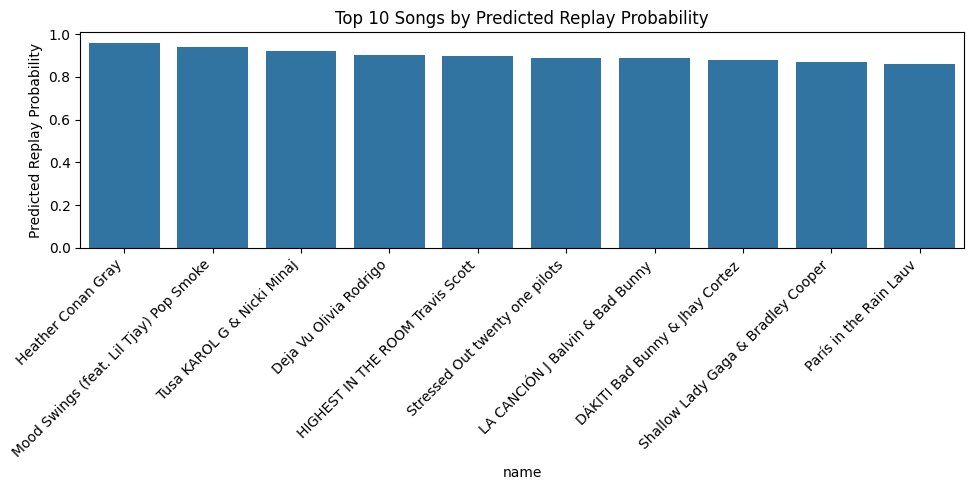

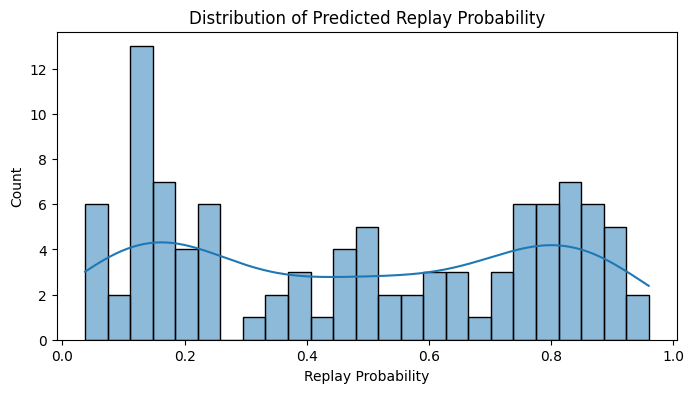

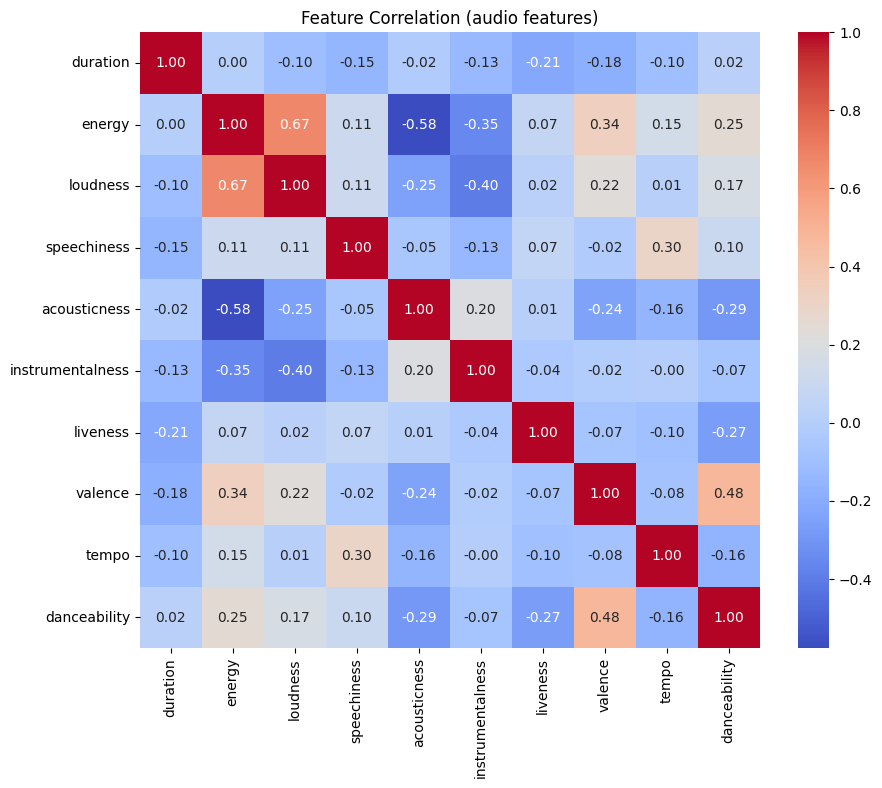

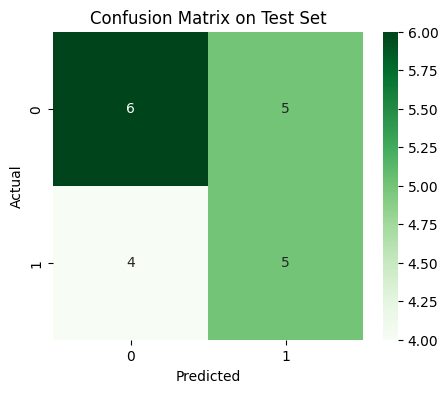

In [20]:
 
plt.rcParams.update({'figure.max_open_warning': 0})

# 1) Top 10 predicted replay songs (bar)
top10 = df.sort_values('replay_prob', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top10['name'], y=top10['replay_prob'])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Songs by Predicted Replay Probability")
plt.ylabel("Predicted Replay Probability")
plt.tight_layout()
plt.show()

# 2) Distribution of replay_prob
plt.figure(figsize=(8,4))
sns.histplot(df['replay_prob'], bins=25, kde=True)
plt.title("Distribution of Predicted Replay Probability")
plt.xlabel("Replay Probability")
plt.show()

# 3) Correlation heatmap of audio features
plt.figure(figsize=(10,8))
sns.heatmap(df[feature_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation (audio features)")
plt.show()

# 4) Confusion matrix visualization (using test set from earlier)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
